In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

In [2]:
DATA_DIR = "/workspace/computer-vision/pytorch_study/data/PennFudanPed/"
IMG_DIR = "/workspace/computer-vision/pytorch_study/data/PennFudanPed/PNGImages/"
MASK_DIR = "/workspace/computer-vision/pytorch_study/data/PennFudanPed/PedMasks/"

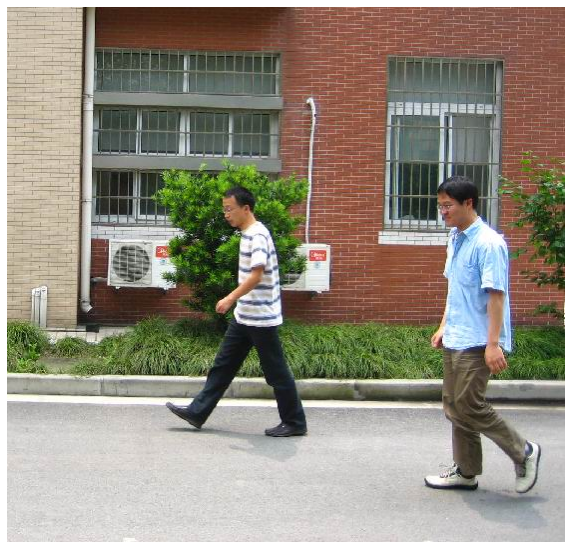

In [3]:
img = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, "FudanPed00001.png")), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
mask = cv2.imread(os.path.join(MASK_DIR, "FudanPed00001_mask.png"))
mask.shape

(536, 559, 3)

In [5]:
COLORMAP = np.array([
    [0, 0, 0],
    [255, 0, 0],
    [255, 255, 0],
    [255, 153, 0],
])

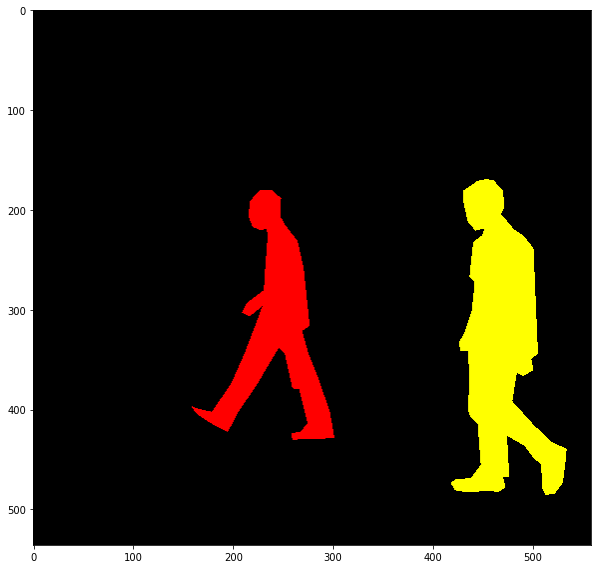

In [6]:
cmap_mask = COLORMAP[mask[..., 0]]

plt.figure(figsize=(10, 10))
plt.imshow(cmap_mask)
plt.show()

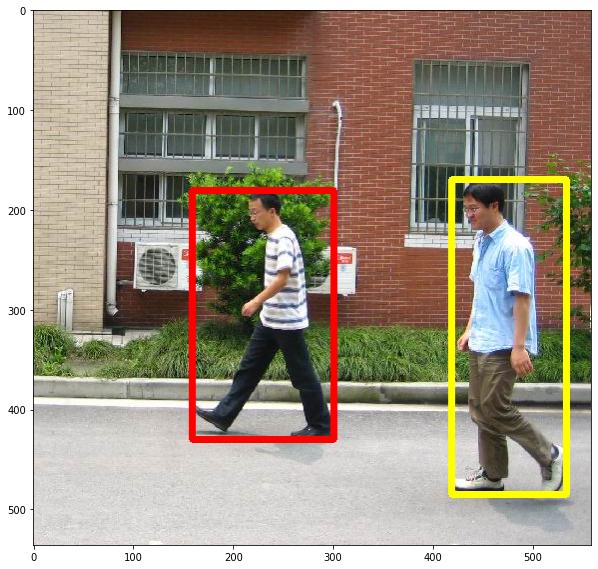

In [7]:
obj_ids = np.unique(mask)[1:]
img_copy = img.copy()

for i in obj_ids:
    pos = np.where(mask == i)
    ymin, xmin, _ = np.min(pos, axis=1)
    ymax, xmax, _ = np.max(pos, axis=1)
    
    img_copy = cv2.rectangle(img_copy, (xmin, ymin), (xmax, ymax), COLORMAP[i].tolist(), 5)

plt.figure(figsize=(10, 10))
plt.imshow(img_copy)
plt.show()

In [8]:
class PennFudanDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        
        obj_ids = np.unique(mask)[1:]
        boxes = []
        for i in obj_ids:
            pos = np.where(mask == i)
            ymin, xmin, _ = np.min(pos, axis=1)
            ymax, xmax, _ = np.max(pos, axis=1)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
"""
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label"""

'\nclass CustomImageDataset(Dataset):\n    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):\n        self.img_labels = pd.read_csv(annotations_file)\n        self.img_dir = img_dir\n        self.transform = transform\n        self.target_transform = target_transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):\n        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])\n        image = read_image(img_path)\n        label = self.img_labels.iloc[idx, 1]\n        if self.transform:\n            image = self.transform(image)\n        if self.target_transform:\n            label = self.target_transform(label)\n        return image, label'